In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Load the weather data and merge them into our two DataFrames.'''
os.chdir(r'D:\Springboard_DataSci\Assignments\Capstone_2--Airport_weather\data')
print('Loading weather events')
weather_events = pd.read_csv('daily_weather.csv')
print(weather_events.columns)
weather_events.drop('index', axis=1, inplace=True)
inputVars = pd.Series(weather_events.columns[2:])

print('Loading flight data')
departing_flights = pd.read_csv('departing_flights.csv')
arriving_flights = pd.read_csv('arriving_flights.csv')

Loading weather events
Index(['Airport', 'Date', 'Cold', 'Fog', 'Hail', 'Wind', 'Rain', 'Sleet',
       'Snow', 'index'],
      dtype='object')
Loading flight data


In [3]:
# Merge the DataFrames.
departure_events = departing_flights.merge(
    weather_events, how='left', left_on=['ORIGIN','DepartureDate'],
    right_on=['Airport','Date'], validate='one_to_many')
arrival_events = arriving_flights.merge(
    weather_events, how='left', left_on=['DEST','ArrivalDate'],
    right_on=['Airport','Date'], validate='one_to_many')

In [4]:
# Drop redundant columns.
print(departure_events.columns)
print(arrival_events.columns)
departure_events.drop(['Airport','Date'], axis=1, inplace=True)
arrival_events.drop(['Airport','Date'], axis=1, inplace=True)

# Clean up the column names.
column_renames = {'ARR_DEL15':'ArrivDelay',
                  'DEP_DEL15':'DepartDelay'}
departure_events.rename(columns=column_renames, inplace=True)
arrival_events.rename(columns=column_renames, inplace=True)

# NaN's mean no weather events on that day. Fill them in with 0's.
for column in inputVars:
    departure_events[column].fillna(0, inplace=True)
    arrival_events[column].fillna(0, inplace=True)

Index(['ORIGIN', 'DepartureDate', 'ARR_DEL15', 'DEP_DEL15', 'Flights',
       'WeatherCancelled', 'WeatherDelayed', 'Airport', 'Date', 'Cold', 'Fog',
       'Hail', 'Wind', 'Rain', 'Sleet', 'Snow'],
      dtype='object')
Index(['DEST', 'ArrivalDate', 'ARR_DEL15', 'DEP_DEL15', 'Flights',
       'WeatherCancelled', 'WeatherDelayed', 'Airport', 'Date', 'Cold', 'Fog',
       'Hail', 'Wind', 'Rain', 'Sleet', 'Snow'],
      dtype='object')


In [5]:
'''Exploratory data analysis'''
FRAC_CANCELLED = 'FracCancelled'
FRAC_DELAYED = 'FracDelayed'
departure_events[FRAC_CANCELLED] = departure_events.WeatherCancelled/departure_events.Flights
arrival_events[FRAC_CANCELLED] = arrival_events.WeatherCancelled/arrival_events.Flights
departure_events[FRAC_DELAYED] = departure_events.WeatherDelayed/departure_events.Flights
arrival_events[FRAC_DELAYED] = arrival_events.WeatherDelayed/arrival_events.Flights

X_dep = departure_events.loc[:, inputVars]
X_arr = arrival_events.loc[:, inputVars]

In [6]:
#Max absolute difference.
maxAbsDiff = lambda A, B, axis=None: np.max(np.abs(A-B), axis=axis)

In [7]:
print('Deviation from X_dep and array of ints:', maxAbsDiff(X_dep, X_dep.astype(int)) )
print('\nDeviation from X_arr and array of ints:', maxAbsDiff(X_arr, X_arr.astype(int)) )
X_dep = X_dep.astype(int)
X_arr = X_arr.astype(int)

print("Deviation between X_dep and X_arr's correlation matrices:")
print(maxAbsDiff(X_dep.corr(), X_arr.corr()))

Deviation from X_dep and array of ints: Cold     0.0
Fog      0.0
Hail     0.0
Wind     0.0
Rain     0.0
Sleet    0.0
Snow     0.0
dtype: float64

Deviation from X_arr and array of ints: Cold     0.0
Fog      0.0
Hail     0.0
Wind     0.0
Rain     0.0
Sleet    0.0
Snow     0.0
dtype: float64
Deviation between X_dep and X_arr's correlation matrices:
Cold     0.000011
Fog      0.000403
Hail     0.000036
Wind     0.000054
Rain     0.000403
Sleet    0.000026
Snow     0.000040
dtype: float64


These deviations are very low, which is to be expected given that X_dep and
X_arr have very similar daily data. We will proceed only with departure events.

In [8]:
Avg = pd.DataFrame(map(list, zip(inputVars.values, np.average(
    X_dep, axis=0, weights=departure_events.Flights))), columns=['Code', 'WtAvg'])
Avg = Avg.set_index('Code')['WtAvg']
print('\nWeighted averages: ' + str(Avg) + '\n')


Weighted averages: Code
Cold     0.001920
Fog      0.166820
Hail     0.000954
Wind     0.006484
Rain     0.491912
Sleet    0.002217
Snow     0.053923
Name: WtAvg, dtype: float64



Now let's do some plots, per code, categorized by code value. To make things
simpler we will not weight these values for now. There are a ton of outliers; we
will do the plots both with and without them.

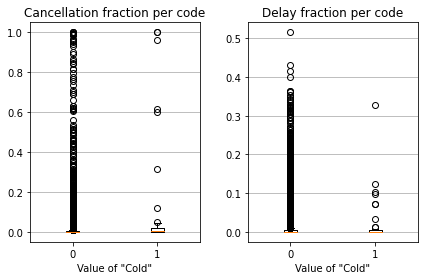

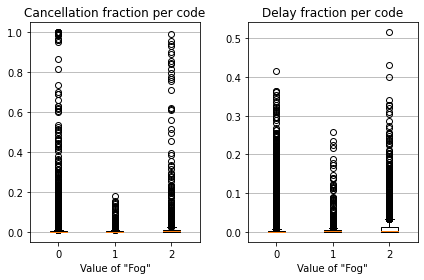

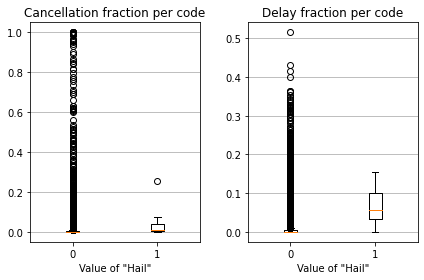

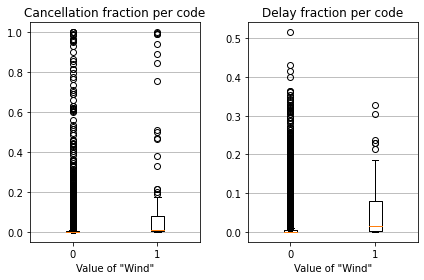

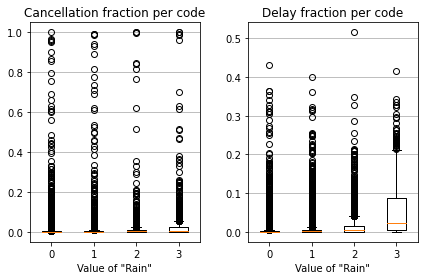

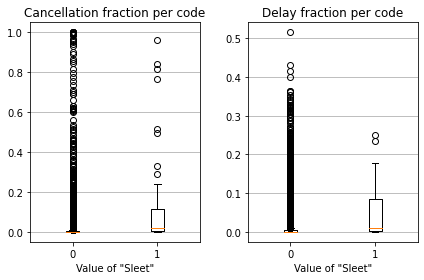

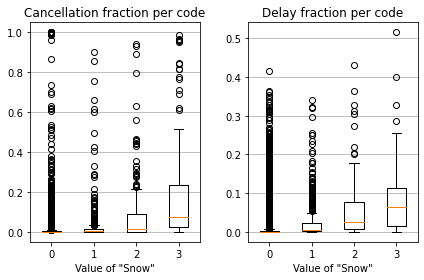

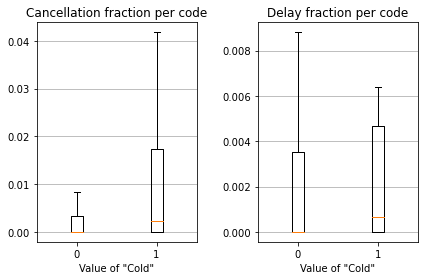

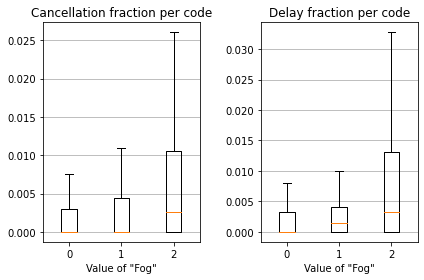

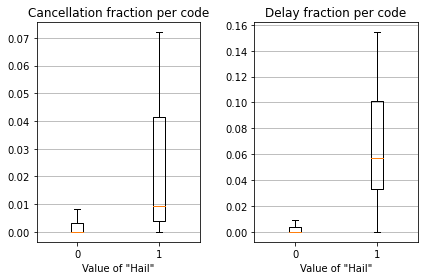

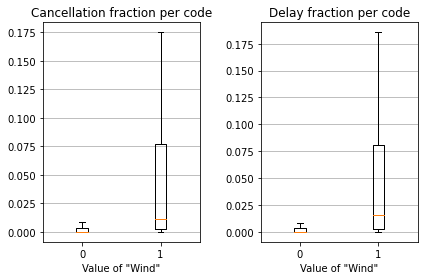

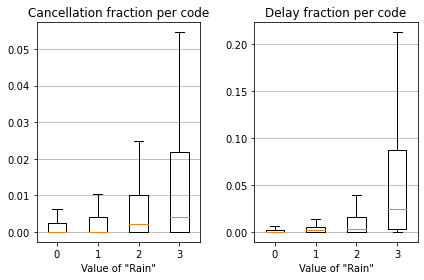

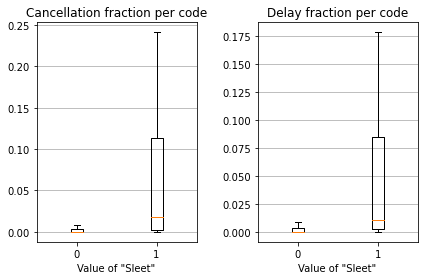

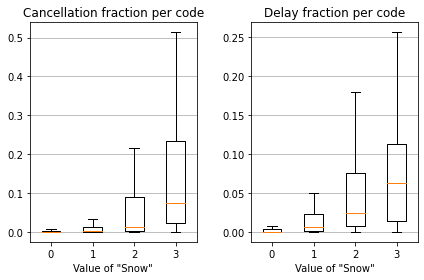

In [9]:
frac_cancelled = departure_events['FracCancelled']
frac_delayed = departure_events['FracDelayed']
os.chdir(r'D:\Springboard_DataSci\Assignments\Capstone_2--Airport_weather\figures')

for showfliers in [True, False]: #Outliers
    for weatherCode in inputVars:
        unique_codes = np.sort(X_dep[weatherCode].unique()) #makes a Series of value counts indexed by code #
        cancelled_per_code = [frac_cancelled[X_dep[weatherCode]==j] for j in unique_codes]
        delayed_per_code = [frac_delayed[X_dep[weatherCode]==j] for j in unique_codes]
    
        fig, axs = plt.subplots(1,2)
        axs[0].boxplot(cancelled_per_code, showfliers=showfliers)
        axs[0].set_title('Cancellation fraction per code')
        axs[1].boxplot(delayed_per_code, showfliers=showfliers)
        axs[1].set_title('Delay fraction per code')
        for j in [0,1]:
            axs[j].set_xticklabels(unique_codes)
            axs[j].set_xlabel('Value of "' + weatherCode + '"')
            axs[j].yaxis.grid(True)
        if not showfliers:
            plt.savefig('BoxPlot' + weatherCode + '.png')
        plt.tight_layout()
        plt.show()

The medians of some of these features clearly are affected by the feature value;
however, none of them seem to add up to much more than about 0.20, meaning that
we should not expect that these weather events will have an overwhelming affect
on delays and cancellations. Still, there do seem to be trends that emerge.

In [10]:
os.chdir(r'D:\Springboard_DataSci\Assignments\Capstone_2--Airport_weather\data')
# Save the results.
# departure_events.to_csv('departure_events.csv') #Uncomment to save.